⚙️ Loading full expression matrix (Parsing ~4000 patients)...
   🧹 Cleaning non-numeric values...
✅ Data Ready: (4113, 2540) (Patients x Genes)

🧠 Phase 1: AI Feature Discovery (Random Forest)...
🏆 Top 10 Discovered Biomarkers:
        Gene  Importance
MIMAT0004508    0.051819
MIMAT0005951    0.033191
MIMAT0022943    0.033022
MIMAT0019947    0.030514
MIMAT0031000    0.026741
MIMAT0027412    0.026521
MIMAT0019848    0.022086
MIMAT0019033    0.021478
MIMAT0003330    0.018734
MIMAT0027623    0.017728

🤖 Phase 2: Training XGBoost on Top Features...

🚀 INNOVATION RESULTS (AI-Driven Panel)
Method:  Full Genome Scan -> Top 10 Features -> XGBoost
--------------------------------------------------
Metric          | Our New Model  
--------------------------------------------------
AUC             | 0.9779
Accuracy        | 95.50%
Sensitivity     | 95.31%
Specificity     | 95.59%


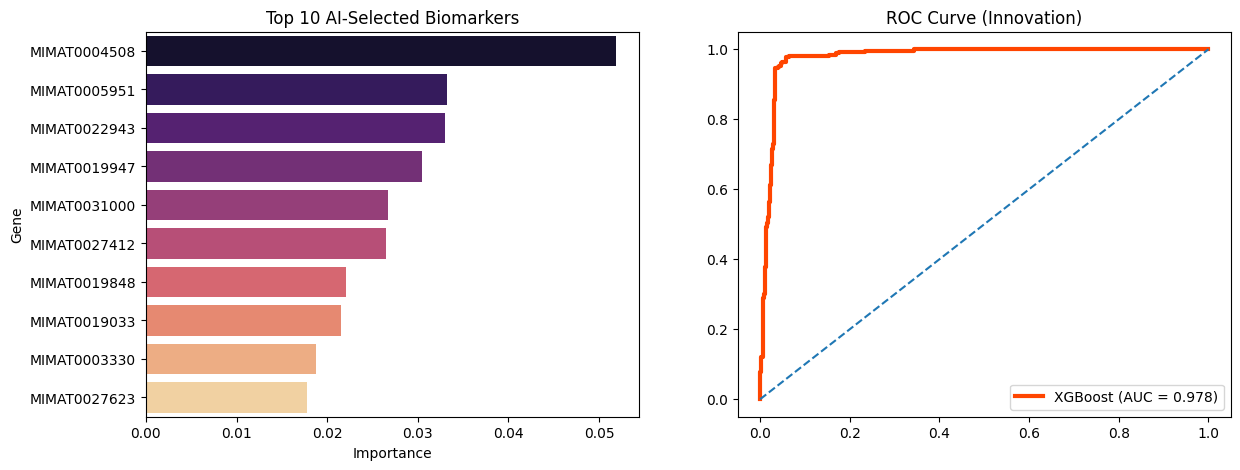

In [4]:
# -*- coding: utf-8 -*-
"""
03_innovation_xgb.ipynb

Title: Innovation - AI-Driven Biomarker Discovery
Description:
    This script moves beyond replication to perform a full genome-wide screening.
    1. Loads the full dataset (~2500 genes).
    2. Uses Random Forest for non-linear Feature Selection.
    3. Trains an XGBoost classifier to outperform the original paper's linear model.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import gzip
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# ==========================================
# 1. Robust Data Loading (Full Dataset)
# ==========================================
GEO_URL = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE73nnn/GSE73002/matrix/GSE73002_series_matrix.txt.gz"
FILE_NAME = "GSE73002_series_matrix.txt.gz"

if not os.path.exists(FILE_NAME):
    print("⏳ Downloading full dataset...")
    with open(FILE_NAME, 'wb') as f: f.write(requests.get(GEO_URL).content)

print("⚙️ Loading full expression matrix (Parsing ~4000 patients)...")

# A) Find Data Start Line
start_line = 0
diagnosis_line = ""
with gzip.open(FILE_NAME, 'rt') as f:
    for i, line in enumerate(f):
        if "!Sample_characteristics_ch1" in line and "diagnosis:" in line:
            diagnosis_line = line
        if "!series_matrix_table_begin" in line:
            start_line = i + 1
            break

# B) Process Labels
samples = diagnosis_line.strip().split('\t')[1:]
y_all = np.array([1 if "breast cancer" in s.replace('"', '').lower() else 0 for s in samples])

# C) Safe CSV Reading
try:
    df_raw = pd.read_csv(FILE_NAME, sep='\t', header=0, skiprows=start_line, index_col=0, compression='gzip')
    # Remove metadata footer if exists
    if df_raw.index[-1].startswith("!"):
        df_raw = df_raw.iloc[:-1]
except Exception as e:
    print(f"❌ Read Error: {e}")

# D) Clean Data (Remove quotes, handle NaNs)
print("   🧹 Cleaning non-numeric values...")
X_all = df_raw.T

# Convert all columns to numeric, coercing errors
for col in X_all.columns:
    if X_all[col].dtype == object:
        X_all[col] = pd.to_numeric(X_all[col].astype(str).str.replace('"', ''), errors='coerce')

X_all.fillna(0, inplace=True)
# Remove constant columns (all zeros)
X_all = X_all.loc[:, (X_all != 0).any(axis=0)]

print(f"✅ Data Ready: {X_all.shape} (Patients x Genes)")

# ==========================================
# 2. Intelligent Feature Selection
# ==========================================
print("\n🧠 Phase 1: AI Feature Discovery (Random Forest)...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_all, y_all)

# Rank Features
importances = rf.feature_importances_
feature_df = pd.DataFrame({'Gene': X_all.columns, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

TOP_N = 10
top_genes = feature_df['Gene'].head(TOP_N).tolist()
print(f"🏆 Top {TOP_N} Discovered Biomarkers:\n{feature_df.head(TOP_N).to_string(index=False)}")

X_opt = X_all[top_genes]

# ==========================================
# 3. Advanced Modeling (XGBoost)
# ==========================================
print("\n🤖 Phase 2: Training XGBoost on Top Features...")
X_train, X_test, y_train, y_test = train_test_split(X_opt, y_all, test_size=0.2, random_state=42, stratify=y_all)

model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, eval_metric='logloss', random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# ==========================================
# 4. Results
# ==========================================
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sens = tp / (tp + fn)
spec = tn / (tn + fp)
roc_auc = auc(*roc_curve(y_test, y_prob)[:2])

print("\n" + "="*50)
print("🚀 INNOVATION RESULTS (AI-Driven Panel)")
print("="*50)
print(f"Method:  Full Genome Scan -> Top {TOP_N} Features -> XGBoost")
print("-" * 50)
print(f"{'Metric':<15} | {'Our New Model':<15}")
print("-" * 50)
print(f"{'AUC':<15} | {roc_auc:.4f}")
print(f"{'Accuracy':<15} | {acc*100:.2f}%")
print(f"{'Sensitivity':<15} | {sens*100:.2f}%")
print(f"{'Specificity':<15} | {spec*100:.2f}%")
print("="*50)

# Visualization
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Gene', data=feature_df.head(10), palette='magma')
plt.title('Top 10 AI-Selected Biomarkers')

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='#FF4500', lw=3, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve (Innovation)')
plt.legend()
plt.show()